<div class="alert alert-block alert-success">

# **1.** **Setup**

<div>

In [1]:
from utils import *

In [2]:
# Set random seeds for reproducibility
tf.random.set_seed(221)
random.seed(221)
np.random.seed(221)
tf.random.set_seed(221)

In [3]:
# Load the train/val split data without preprocessing
with open('train_val_split_no_preproc.pkl', 'rb') as f:
    data_no_preproc = pickle.load(f)

# Convert DataFrames to list
train_texts = data_no_preproc['x_train'].tolist()
val_texts = data_no_preproc['x_val'].tolist()

# Convert Series to list
train_labels = data_no_preproc['y_train'].tolist()
val_labels = data_no_preproc['y_val'].tolist()

In [4]:
# Load variables from .env into environment
load_dotenv()

# Print environment variable
print("AZURE_OPENAI_ENDPOINT:", os.getenv("AZURE_OPENAI_ENDPOINT"))

# Initialize Azure OpenAI client
client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_KEY"),
    api_version="2024-02-01",
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT")
)

# Define embedding model
model = "text-embedding-3-small"

AZURE_OPENAI_ENDPOINT: https://novaimsplayground.openai.azure.com/


<div class="alert alert-block alert-success">

# **2.** **Models**

<div>

## **2.1** DistilBERT (Encoder)

### **2.1.1** Original

In [ ]:
# Tokenizer & Model
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3, ignore_mismatched_sizes=True)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenization function
def tokenize(example):
    return tokenizer(example["text"],truncation=True)

# Tokenize and convert to Dataset
train_ds = Dataset.from_dict({"text": train_texts, "label": train_labels}).map(tokenize, batched=True)
val_ds = Dataset.from_dict({"text": val_texts, "label": val_labels}).map(tokenize, batched=True)
dataset = DatasetDict({"train": train_ds, "validation": val_ds})

Map: 100%|██████████| 1909/1909 [00:00<00:00, 44226.41 examples/s]


In [ ]:
training_args = TrainingArguments(
    output_dir="./results/distilbert_default",      # Where model checkpoints and logs go
    learning_rate=2e-5,                             # Standard learning rate for fine-tuning
    per_device_train_batch_size=16,                 # Small enough for most GPUs
    per_device_eval_batch_size=32,                  # Larger eval batch size is okay for speed
    num_train_epochs=5,                             # 4 epochs — sufficient for many transformer tasks
    weight_decay=0.01,                              # Regularization to avoid overfitting
    logging_dir="./logs",                           # Logs directory
    logging_steps=100,                              # Log every 100 steps
    eval_strategy="no",                             # Don't evaluate at the end of every epoch
    save_strategy="no",                             # Don't save model at the end of every epoch        
    load_best_model_at_end=True,                    # Keep best model based on metric
    metric_for_best_model="loss",                   # Use val loss to select best model
    greater_is_better=False,                        # Because lower loss is better
    report_to=[]                                    # Disable WandB or other loggers
)

In [ ]:
# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics_transformers
)

# Train the model
trainer.train()

Step,Training Loss
100,0.815700
200,0.565400
300,0.499900
400,0.476600
500,0.427400
600,0.323800
700,0.329200
800,0.313900
900,0.311400
1000,0.243300


TrainOutput(global_step=2390, training_loss=0.24840018779164078, metrics={'train_runtime': 1363.6247, 'train_samples_per_second': 27.992, 'train_steps_per_second': 1.753, 'total_flos': 513212692287168.0, 'train_loss': 0.24840018779164078, 'epoch': 5.0})

In [ ]:
# Save model and tokenizer
trainer.save_model("distilbert_default")
tokenizer.save_pretrained("distilbert_default")

('distilbert_default/tokenizer_config.json',
 'distilbert_default/special_tokens_map.json',
 'distilbert_default/vocab.txt',
 'distilbert_default/added_tokens.json',
 'distilbert_default/tokenizer.json')

In [ ]:
# Evaluate on training set
train_metrics = trainer.evaluate(eval_dataset=dataset["train"])
print("\nTraining Set Evaluation Metrics:")
for key, value in train_metrics.items():
    print(f"{key}: {value:.4f}")

# Evaluate on validation set
val_metrics = trainer.evaluate(eval_dataset=dataset["validation"])
print("\nValidation Set Evaluation Metrics:")
for key, value in val_metrics.items():
    print(f"{key}: {value:.4f}")


Training Set Evaluation Metrics:
eval_loss: 0.0421
eval_accuracy: 0.9903
eval_precision: 0.9850
eval_recall: 0.9878
eval_f1: 0.9864
eval_runtime: 108.9043
eval_samples_per_second: 70.0980
eval_steps_per_second: 2.1950
epoch: 5.0000

Validation Set Evaluation Metrics:
eval_loss: 0.6072
eval_accuracy: 0.8649
eval_precision: 0.8246
eval_recall: 0.8188
eval_f1: 0.8216
eval_runtime: 15.1542
eval_samples_per_second: 125.9720
eval_steps_per_second: 3.9590
epoch: 5.0000


In [ ]:
train_preds = trainer.predict(dataset["train"])
val_preds = trainer.predict(dataset["validation"])

train_pred_distilbert = np.argmax(train_preds.predictions, axis=1)
val_pred_distilbert = np.argmax(val_preds.predictions, axis=1)

In [ ]:
# Define the title for the metrics and plots
title = "DistilBERT Market Sentiment"

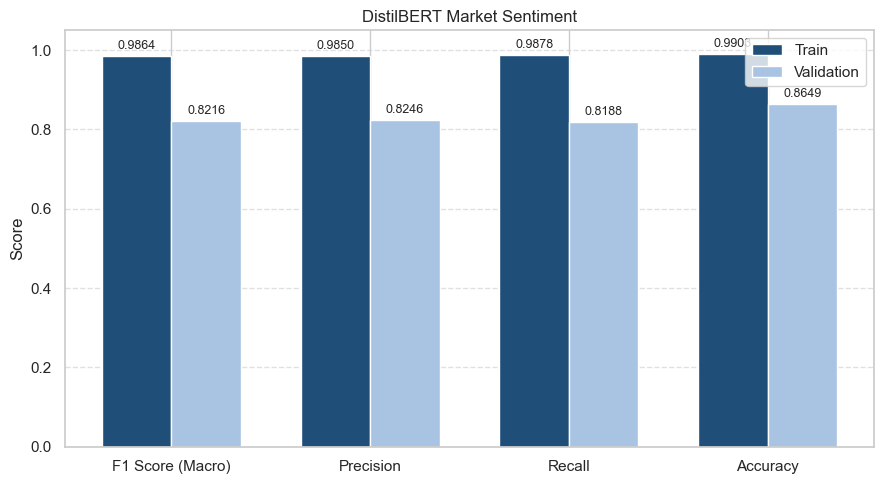

In [ ]:
# Get metrics DataFrame
metrics_df = get_metrics_df(title, train_labels, train_pred_distilbert, val_labels, val_pred_distilbert)
metrics_df

# Plot metrics
plot_metrics(train_labels, train_pred_distilbert, val_labels, val_pred_distilbert, title=title)

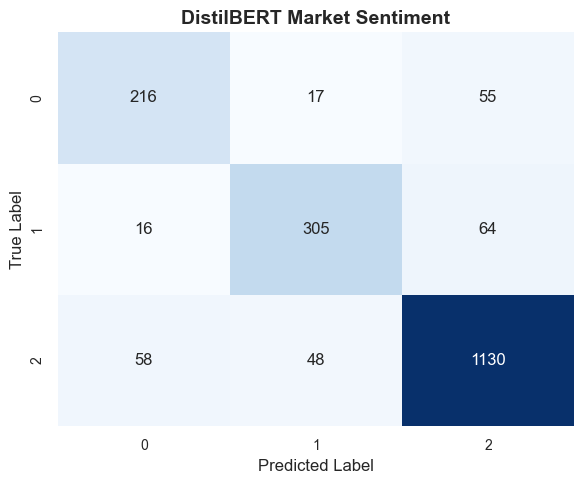

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(val_labels, val_pred_distilbert, title=title, labels=[0, 1, 2], cmap="Blues")

### **2.1.2** Weighted and Oversampled

In [ ]:
# Tokenizer & Model
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3, ignore_mismatched_sizes=True)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Oversample
train_texts_over, train_labels_over = oversample_data(train_texts, train_labels)

In [ ]:
# Tokenize and convert to Dataset
train_ds = Dataset.from_dict({"text": train_texts_over, "label": train_labels_over}).map(tokenize, batched=True)
val_ds = Dataset.from_dict({"text": val_texts, "label": val_labels}).map(tokenize, batched=True)
dataset = DatasetDict({"train": train_ds, "validation": val_ds})

Map: 100%|██████████| 1909/1909 [00:00<00:00, 49756.26 examples/s]


In [ ]:
# Weighted loss
class_weights = torch.tensor(
    np.bincount(train_labels, minlength=3) / len(train_labels),
    dtype=torch.float
)
class_weights = 1.0 / class_weights
model.classifier.loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results/distilbert_oversampling_weighted",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",                     # Logs directory
    logging_steps=100,                        # Log every 100 steps
    eval_strategy="no",                       # Don't evaluate at the end of every epoch
    save_strategy="no",                       # Don't save model at the end of every epoch       
    load_best_model_at_end=True,              # Keep best model based on metric
    metric_for_best_model="f1",               # Use F1 to choose the best model
    greater_is_better=True,                   # Because higher F1 is better
    report_to=[]                              # Disable WandB or other loggers
)

In [ ]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics_transformers
)

/var/folders/19/rxl10lh147s73036f239kkmm0000gn/T/ipykernel_16817/3301814314.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Step,Training Loss
100,0.932200
200,0.591500
300,0.541300
400,0.392500
500,0.358500
600,0.293000
700,0.298800
800,0.245200
900,0.230400
1000,0.130300


TrainOutput(global_step=4635, training_loss=0.12226123088386066, metrics={'train_runtime': 2482.6647, 'train_samples_per_second': 29.859, 'train_steps_per_second': 1.867, 'total_flos': 984047997546756.0, 'train_loss': 0.12226123088386066, 'epoch': 5.0})

In [ ]:
trainer.save_model("distilbert_oversampling_weighted")
tokenizer.save_pretrained("distilbert_oversampling_weighted")

('distilbert_oversampling_weighted/tokenizer_config.json',
 'distilbert_oversampling_weighted/special_tokens_map.json',
 'distilbert_oversampling_weighted/vocab.txt',
 'distilbert_oversampling_weighted/added_tokens.json',
 'distilbert_oversampling_weighted/tokenizer.json')

In [ ]:
# Evaluate on training set
train_metrics = trainer.evaluate(eval_dataset=dataset["train"])
print("\nTraining Set Evaluation Metrics:")
for key, value in train_metrics.items():
    print(f"{key}: {value:.4f}")

# Evaluate on validation set
val_metrics = trainer.evaluate(eval_dataset=dataset["validation"])
print("\nValidation Set Evaluation Metrics:")
for key, value in val_metrics.items():
    print(f"{key}: {value:.4f}")


Training Set Evaluation Metrics:
eval_loss: 0.0041
eval_accuracy: 0.9989
eval_precision: 0.9989
eval_recall: 0.9989
eval_f1: 0.9989
eval_runtime: 176.2452
eval_samples_per_second: 84.1210
eval_steps_per_second: 2.6330
epoch: 5.0000

Validation Set Evaluation Metrics:
eval_loss: 1.0166
eval_accuracy: 0.8481
eval_precision: 0.7965
eval_recall: 0.8155
eval_f1: 0.8052
eval_runtime: 17.2666
eval_samples_per_second: 110.5600
eval_steps_per_second: 3.4750
epoch: 5.0000


In [ ]:
train_preds = trainer.predict(dataset["train"])
val_preds = trainer.predict(dataset["validation"])

train_pred_distilbert = np.argmax(train_preds.predictions, axis=1)
val_pred_distilbert = np.argmax(val_preds.predictions, axis=1)

In [ ]:
# Define the title for the metrics and plots
title = "DistilBERT Market Sentiment - Weighted and Oversampled"

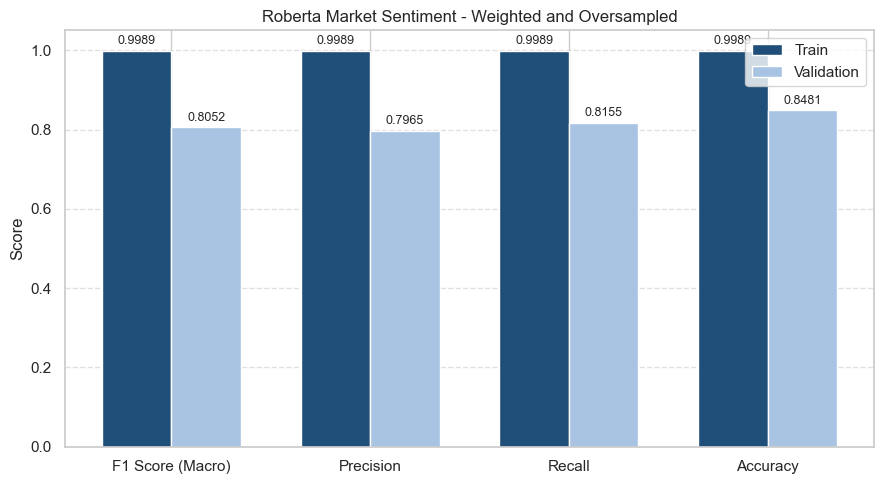

In [ ]:
# Get metrics DataFrame
metrics_df = get_metrics_df(title, train_labels_over, train_pred_distilbert, val_labels, val_pred_distilbert)
metrics_df

# Plot metrics
plot_metrics(train_labels_over, train_pred_distilbert, val_labels, val_pred_distilbert, title=title)

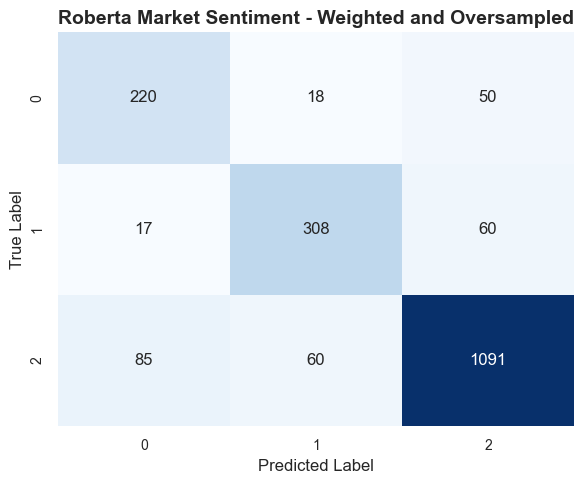

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(val_labels, val_pred_distilbert, title=title, labels=[0, 1, 2], cmap="Blues")

### **2.1.3** Final

In [ ]:
# Tokenizer & Model
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# droupout
config = AutoConfig.from_pretrained(checkpoint, num_labels=3, hidden_dropout_prob=0.3, attention_probs_dropout_prob=0.3)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config, ignore_mismatched_sizes=True)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Oversample
train_texts_over, train_labels_over = oversample_data(train_texts, train_labels)

In [ ]:
# Tokenization function
def tokenize(example):
    return tokenizer(example["text"],truncation=True)

# Tokenize and convert to Dataset
train_ds = Dataset.from_dict({"text": train_texts_over, "label": train_labels_over}).map(tokenize, batched=True)
val_ds = Dataset.from_dict({"text": val_texts, "label": val_labels}).map(tokenize, batched=True)
dataset = DatasetDict({"train": train_ds, "validation": val_ds})

Map: 100%|██████████| 1909/1909 [00:00<00:00, 50701.14 examples/s]


In [ ]:
# Weighted loss
class_weights = torch.tensor(
    np.bincount(train_labels, minlength=3) / len(train_labels),
    dtype=torch.float
)
class_weights = 1.0 / class_weights
model.classifier.loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results/distilbert_oversampling_weighted_dropout",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",                     # Logs directory
    logging_steps=100,                        # Log every 100 steps
    eval_strategy="no",                       # Don't evaluate at the end of every epoch
    save_strategy="no",                       # Don't save model at the end of every epoch       
    load_best_model_at_end=True,              # Keep best model based on metric
    metric_for_best_model="loss",             # Use val loss to select best model
    greater_is_better=False,                  # Because lower loss is better
    report_to=[]                              # Disable WandB or other loggers
)

In [ ]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics_transformers
)

/var/folders/19/rxl10lh147s73036f239kkmm0000gn/T/ipykernel_16817/3301814314.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Step,Training Loss
100,0.932200
200,0.591500
300,0.541300
400,0.392500
500,0.358500
600,0.293000
700,0.298800
800,0.245200
900,0.230400
1000,0.130300


TrainOutput(global_step=4635, training_loss=0.12177179071734767, metrics={'train_runtime': 1979.9855, 'train_samples_per_second': 37.44, 'train_steps_per_second': 2.341, 'total_flos': 984047997546756.0, 'train_loss': 0.12177179071734767, 'epoch': 5.0})

In [ ]:
trainer.save_model("distilbert_oversampling_weighted_dropout")
tokenizer.save_pretrained("distilbert_oversampling_weighted_dropout")

('distilbert_oversampling_weighted_dropout/tokenizer_config.json',
 'distilbert_oversampling_weighted_dropout/special_tokens_map.json',
 'distilbert_oversampling_weighted_dropout/vocab.txt',
 'distilbert_oversampling_weighted_dropout/added_tokens.json',
 'distilbert_oversampling_weighted_dropout/tokenizer.json')

In [ ]:
# Evaluate on training set
train_metrics = trainer.evaluate(eval_dataset=dataset["train"])
print("\nTraining Set Evaluation Metrics:")
for key, value in train_metrics.items():
    print(f"{key}: {value:.4f}")

# Evaluate on validation set
val_metrics = trainer.evaluate(eval_dataset=dataset["validation"])
print("\nValidation Set Evaluation Metrics:")
for key, value in val_metrics.items():
    print(f"{key}: {value:.4f}")


Training Set Evaluation Metrics:
eval_loss: 0.0050
eval_accuracy: 0.9989
eval_precision: 0.9989
eval_recall: 0.9989
eval_f1: 0.9989
eval_runtime: 114.0545
eval_samples_per_second: 129.9900
eval_steps_per_second: 4.0680
epoch: 5.0000

Validation Set Evaluation Metrics:
eval_loss: 1.0163
eval_accuracy: 0.8512
eval_precision: 0.8016
eval_recall: 0.8163
eval_f1: 0.8085
eval_runtime: 10.8199
eval_samples_per_second: 176.4340
eval_steps_per_second: 5.5450
epoch: 5.0000


In [ ]:
train_preds = trainer.predict(dataset["train"])
val_preds = trainer.predict(dataset["validation"])

train_pred_distilbert = np.argmax(train_preds.predictions, axis=1)
val_pred_distilbert = np.argmax(val_preds.predictions, axis=1)

In [ ]:
# Define the title for the metrics and plots
title = "DistilBERT Market Sentiment - Weighted, Oversampled and with Dropout"

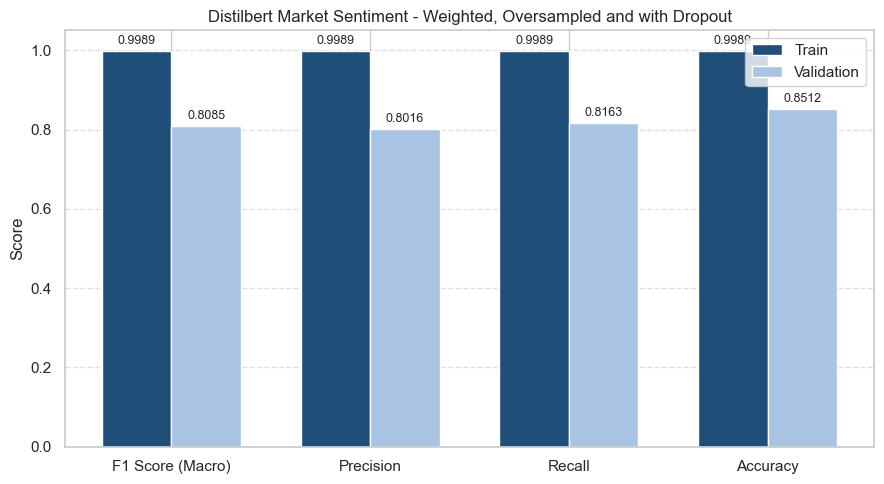

In [ ]:
# Get metrics DataFrame
metrics_df = get_metrics_df(title, train_labels_over, train_pred_distilbert, val_labels, val_pred_distilbert)
metrics_df

# Plot metrics
plot_metrics(train_labels_over, train_pred_distilbert, val_labels, val_pred_distilbert, title=title)

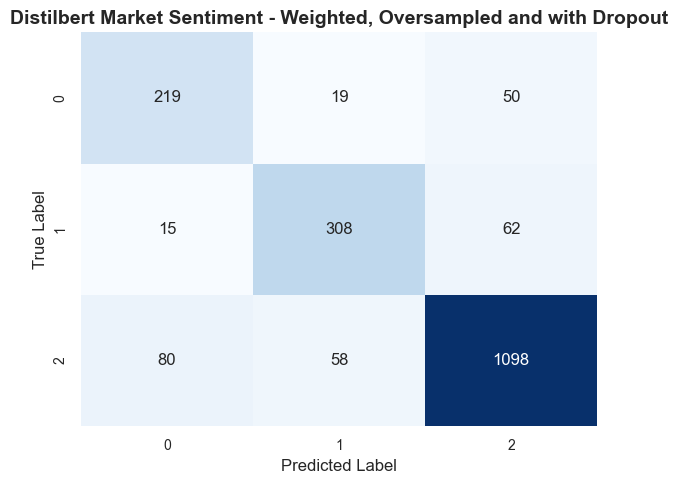

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(val_labels, val_pred_distilbert, title=title, labels=[0, 1, 2], cmap="Blues")

## **2.2** RoBERTa (Encoder) - EXTRA

### **2.2.1** Original

In [ ]:
# Tokenizer & Model
checkpoint = "cardiffnlp/twitter-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",                   # Where model checkpoints and logs go
    learning_rate=2e-5,                       # Standard learning rate for fine-tuning
    per_device_train_batch_size=16,           # Small enough for most GPUs
    per_device_eval_batch_size=32,            # Larger eval batch size is okay for speed
    num_train_epochs=5,                       # 4 epochs — sufficient for many transformer tasks
    weight_decay=0.01,                        # Regularization to avoid overfitting
    logging_dir="./logs",                     # Logs directory
    logging_steps=100,                        # Log every 100 steps
    eval_strategy="epoch",                    # Evaluate at the end of every epoch
    save_strategy="epoch",                    # Save model at the end of every epoch        
    load_best_model_at_end=True,              # Keep best model based on metric
    metric_for_best_model="f1",               # Use F1 to choose the best model
    greater_is_better=True,                   # Because higher F1 is better
    report_to=[]                              # Disable WandB or other loggers
)

In [ ]:
# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics_transformers
)

# Train the model
trainer.train()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.039200,0.853240,0.878470,0.884776,0.878470,0.880082
2,0.149900,0.742684,0.875851,0.880145,0.875851,0.876691
3,0.132800,0.643052,0.891566,0.890514,0.891566,0.890723
4,0.033200,0.757844,0.888423,0.889079,0.888423,0.888708
5,0.050100,0.814385,0.884233,0.888757,0.884233,0.885644


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pin

TrainOutput(global_step=2390, training_loss=0.07231285018402163, metrics={'train_runtime': 2121.8095, 'train_samples_per_second': 17.989, 'train_steps_per_second': 1.126, 'total_flos': 2011082741521056.0, 'train_loss': 0.07231285018402163, 'epoch': 5.0})

In [ ]:
# Save model and tokenizer
trainer.save_model("roberta-market-sentiment")
tokenizer.save_pretrained("roberta-market-sentiment")

('roberta-market-sentiment/tokenizer_config.json',
 'roberta-market-sentiment/special_tokens_map.json',
 'roberta-market-sentiment/vocab.json',
 'roberta-market-sentiment/merges.txt',
 'roberta-market-sentiment/added_tokens.json',
 'roberta-market-sentiment/tokenizer.json')

In [ ]:
# Evaluate on training set
train_metrics = trainer.evaluate(eval_dataset=dataset["train"])
print("\nTraining Set Evaluation Metrics:")
for key, value in train_metrics.items():
    print(f"{key}: {value:.4f}")

# Evaluate on validation set
val_metrics = trainer.evaluate(eval_dataset=dataset["validation"])
print("\nValidation Set Evaluation Metrics:")
for key, value in val_metrics.items():
    print(f"{key}: {value:.4f}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Training Set Evaluation Metrics:
eval_loss: 0.0139
eval_accuracy: 0.9967
eval_precision: 0.9967
eval_recall: 0.9967
eval_f1: 0.9967
eval_runtime: 97.0996
eval_samples_per_second: 78.6200
eval_steps_per_second: 2.4610
epoch: 5.0000


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Validation Set Evaluation Metrics:
eval_loss: 0.8144
eval_accuracy: 0.8842
eval_precision: 0.8888
eval_recall: 0.8842
eval_f1: 0.8856
eval_runtime: 21.0067
eval_samples_per_second: 90.8760
eval_steps_per_second: 2.8560
epoch: 5.0000


In [ ]:
train_preds = trainer.predict(dataset["train"])
val_preds = trainer.predict(dataset["validation"])

train_pred_roberta = np.argmax(train_preds.predictions, axis=1)
val_pred_roberta = np.argmax(val_preds.predictions, axis=1)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [ ]:
# Define the title for the metrics and plots
title = "Roberta Market Sentiment"

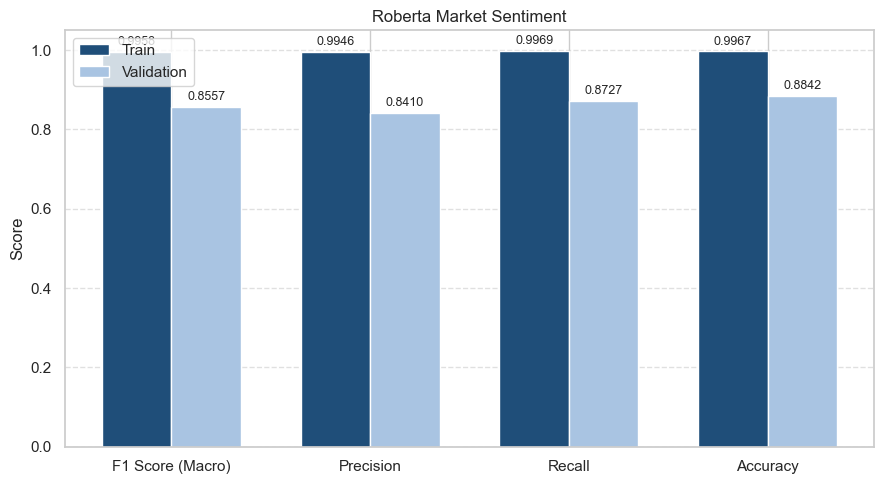

In [ ]:
# Get metrics DataFrame
metrics_df = get_metrics_df(title, train_labels, train_pred_roberta, val_labels, val_pred_roberta)
metrics_df

# Plot metrics
plot_metrics(train_labels, train_pred_roberta, val_labels, val_pred_roberta, title=title)

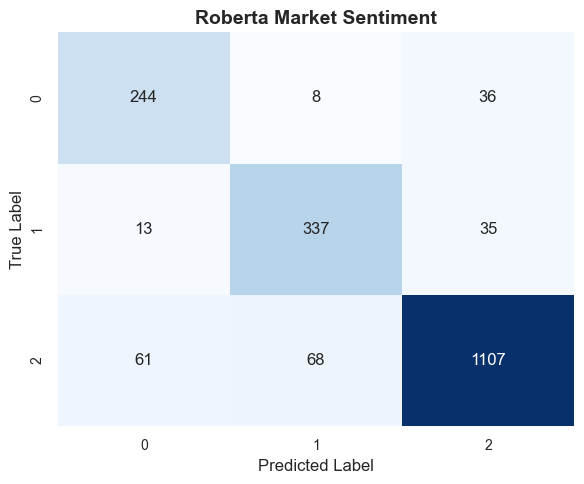

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(val_labels, val_pred_roberta, title=title, labels=[0, 1, 2], cmap="Blues")

### **2.2.2** Weighted and Oversampled

In [ ]:
# Tokenizer & Model
checkpoint = "cardiffnlp/twitter-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Oversample
train_texts_over, train_labels_over = oversample_data(train_texts, train_labels)

In [ ]:
# Tokenize and convert to Dataset
train_ds = Dataset.from_dict({"text": train_texts, "label": train_labels}).map(tokenize, batched=True)
val_ds = Dataset.from_dict({"text": val_texts, "label": val_labels}).map(tokenize, batched=True)
dataset = DatasetDict({"train": train_ds, "validation": val_ds})

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

In [ ]:
# Weighted loss
class_weights = torch.tensor(
    np.bincount(train_labels, minlength=3) / len(train_labels),
    dtype=torch.float
)
class_weights = 1.0 / class_weights
model.classifier.loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results/roberta_oversampling_weighted",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",                     # Logs directory
    logging_steps=100,                        # Log every 100 steps
    eval_strategy="no",                    # Evaluate at the end of every epoch
    save_strategy="no",                    # Save model at the end of every epoch       
    load_best_model_at_end=True,              # Keep best model based on metric
    metric_for_best_model="f1",               # Use F1 to choose the best model
    greater_is_better=True,                   # Because higher F1 is better
    report_to=[]                              # Disable WandB or other loggers
)

In [ ]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics_transformers
)

/var/folders/vr/c8clls693rl3z4mp61z036p80000gn/T/ipykernel_2374/1297415999.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


2025-06-14 15:50:38.025 Python[2374:36552] Error creating directory 
 The volume ‚ÄúMacintosh HD‚Äù is out of space. You can‚Äôt save the file ‚Äúmpsgraph-2374-2025-06-14_15_50_37-1093773328‚Äù because the volume ‚ÄúMacintosh HD‚Äù is out of space.


Step,Training Loss
100,0.139200
200,0.091900
300,0.105100
400,0.127600
500,0.101500
600,0.073400
700,0.055600
800,0.081500
900,0.045400
1000,0.033100


TrainOutput(global_step=2390, training_loss=0.059043699228613945, metrics={'train_runtime': 3371.6357, 'train_samples_per_second': 11.321, 'train_steps_per_second': 0.709, 'total_flos': 2011082741521056.0, 'train_loss': 0.059043699228613945, 'epoch': 5.0})

In [ ]:
trainer.save_model("roberta-weighted-oversampling")
tokenizer.save_pretrained("roberta-weighted-oversampling")

('roberta-weighted-oversampling/tokenizer_config.json',
 'roberta-weighted-oversampling/special_tokens_map.json',
 'roberta-weighted-oversampling/vocab.json',
 'roberta-weighted-oversampling/merges.txt',
 'roberta-weighted-oversampling/added_tokens.json',
 'roberta-weighted-oversampling/tokenizer.json')

In [ ]:
# Evaluate on training set
train_metrics = trainer.evaluate(eval_dataset=dataset["train"])
print("\nTraining Set Evaluation Metrics:")
for key, value in train_metrics.items():
    print(f"{key}: {value:.4f}")

# Evaluate on validation set
val_metrics = trainer.evaluate(eval_dataset=dataset["validation"])
print("\nValidation Set Evaluation Metrics:")
for key, value in val_metrics.items():
    print(f"{key}: {value:.4f}")


Training Set Evaluation Metrics:
eval_loss: 0.0083
eval_accuracy: 0.9982
eval_precision: 0.9973
eval_recall: 0.9980
eval_f1: 0.9976
eval_runtime: 164.2202
eval_samples_per_second: 46.4860
eval_steps_per_second: 1.4550
epoch: 5.0000


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Validation Set Evaluation Metrics:
eval_loss: 0.7790
eval_accuracy: 0.8937
eval_precision: 0.8572
eval_recall: 0.8681
eval_f1: 0.8625
eval_runtime: 40.0862
eval_samples_per_second: 47.6220
eval_steps_per_second: 1.4970
epoch: 5.0000


In [ ]:
train_preds = trainer.predict(dataset["train"])
val_preds = trainer.predict(dataset["validation"])

train_pred_roberta = np.argmax(train_preds.predictions, axis=1)
val_pred_roberta = np.argmax(val_preds.predictions, axis=1)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [ ]:
# Define the title for the metrics and plots
title = "Roberta Market Sentiment - Weighted and Oversampled"

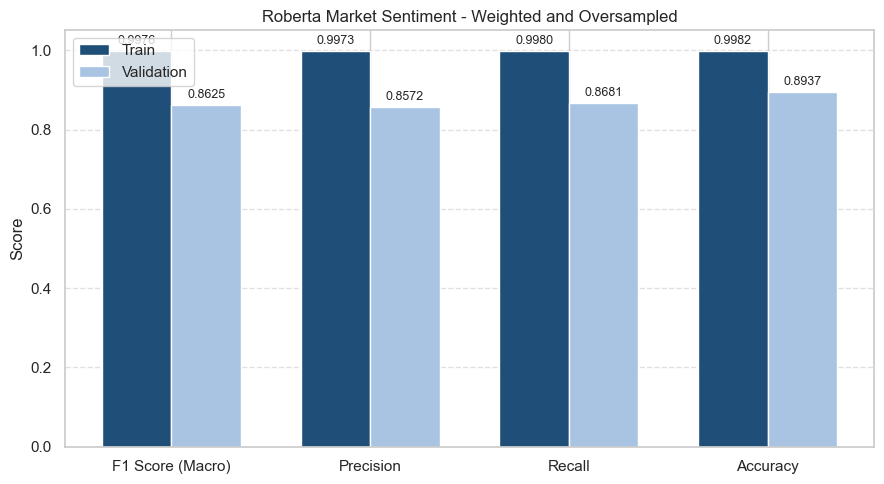

In [ ]:
# Get metrics DataFrame
metrics_df = get_metrics_df(title, train_labels, train_pred_roberta, val_labels, val_pred_roberta)
metrics_df

# Plot metrics
plot_metrics(train_labels, train_pred_roberta, val_labels, val_pred_roberta, title=title)

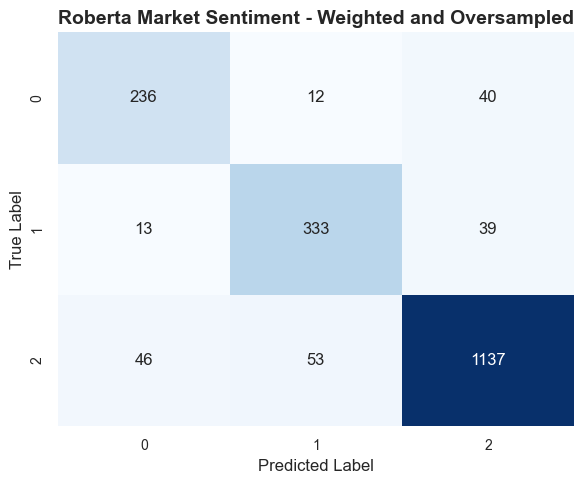

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(val_labels, val_pred_roberta, title=title, labels=[0, 1, 2], cmap="Blues")

### **2.2.3** Final

In [ ]:
# Tokenizer & Model
checkpoint = "cardiffnlp/twitter-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# droupout
config = AutoConfig.from_pretrained(checkpoint, num_labels=3, hidden_dropout_prob=0.3, attention_probs_dropout_prob=0.3)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Oversample
train_texts_over, train_labels_over = oversample_data(train_texts, train_labels)

In [ ]:
# Tokenize and convert to Dataset
train_ds = Dataset.from_dict({"text": train_texts, "label": train_labels}).map(tokenize, batched=True)
val_ds = Dataset.from_dict({"text": val_texts, "label": val_labels}).map(tokenize, batched=True)
dataset = DatasetDict({"train": train_ds, "validation": val_ds})

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

In [ ]:
# Weighted loss
class_weights = torch.tensor(
    np.bincount(train_labels, minlength=3) / len(train_labels),
    dtype=torch.float
)
class_weights = 1.0 / class_weights
model.classifier.loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results/roberta_oversampling_weighted_dropout",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",                     # Logs directory
    logging_steps=100,                        # Log every 100 steps
    eval_strategy="no",                    # Evaluate at the end of every epoch
    save_strategy="no",                    # Save model at the end of every epoch       
    load_best_model_at_end=True,              # Keep best model based on metric
    metric_for_best_model="f1",               # Use F1 to choose the best model
    greater_is_better=True,                   # Because higher F1 is better
    report_to=[]                              # Disable WandB or other loggers
)

In [ ]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics_transformers
)

/var/folders/vr/c8clls693rl3z4mp61z036p80000gn/T/ipykernel_6393/3301814314.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Step,Training Loss
100,0.870200
200,0.712600
300,0.594400
400,0.550900
500,0.537500
600,0.483200
700,0.487300
800,0.479400
900,0.468500
1000,0.428300


TrainOutput(global_step=2390, training_loss=0.44928754622966177, metrics={'train_runtime': 3007.9704, 'train_samples_per_second': 12.69, 'train_steps_per_second': 0.795, 'total_flos': 2011082741521056.0, 'train_loss': 0.44928754622966177, 'epoch': 5.0})

In [ ]:
trainer.save_model("roberta-weighted-oversampling-dropout")
tokenizer.save_pretrained("roberta-weighted-oversampling-dropout")

('roberta-weighted-oversampling-dropout/tokenizer_config.json',
 'roberta-weighted-oversampling-dropout/special_tokens_map.json',
 'roberta-weighted-oversampling-dropout/vocab.json',
 'roberta-weighted-oversampling-dropout/merges.txt',
 'roberta-weighted-oversampling-dropout/added_tokens.json',
 'roberta-weighted-oversampling-dropout/tokenizer.json')

In [ ]:
# Evaluate on training set
train_metrics = trainer.evaluate(eval_dataset=dataset["train"])
print("\nTraining Set Evaluation Metrics:")
for key, value in train_metrics.items():
    print(f"{key}: {value:.4f}")

# Evaluate on validation set
val_metrics = trainer.evaluate(eval_dataset=dataset["validation"])
print("\nValidation Set Evaluation Metrics:")
for key, value in val_metrics.items():
    print(f"{key}: {value:.4f}")


Training Set Evaluation Metrics:
eval_loss: 0.3173
eval_accuracy: 0.8901
eval_precision: 0.8415
eval_recall: 0.9038
eval_f1: 0.8679
eval_runtime: 150.4725
eval_samples_per_second: 50.7340
eval_steps_per_second: 1.5880
epoch: 5.0000


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Validation Set Evaluation Metrics:
eval_loss: 0.4018
eval_accuracy: 0.8591
eval_precision: 0.8060
eval_recall: 0.8607
eval_f1: 0.8294
eval_runtime: 40.2947
eval_samples_per_second: 47.3760
eval_steps_per_second: 1.4890
epoch: 5.0000


In [ ]:
train_preds = trainer.predict(dataset["train"])
val_preds = trainer.predict(dataset["validation"])

train_pred_roberta = np.argmax(train_preds.predictions, axis=1)
val_pred_roberta = np.argmax(val_preds.predictions, axis=1)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [ ]:
# Define the title for the metrics and plots
title = "Roberta Market Sentiment - Weighted, Oversampled and with Dropout"

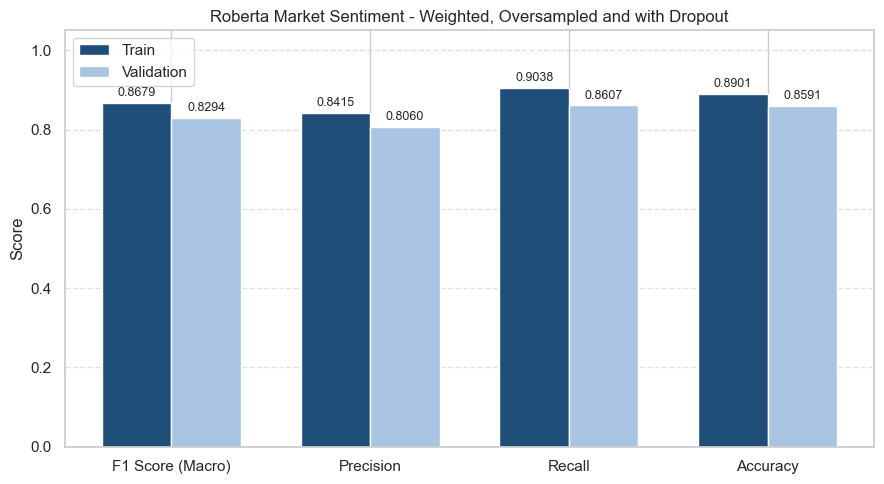

In [ ]:
# Get metrics DataFrame
metrics_df = get_metrics_df(title, train_labels, train_pred_roberta, val_labels, val_pred_roberta)
metrics_df

# Plot metrics
plot_metrics(train_labels, train_pred_roberta, val_labels, val_pred_roberta, title=title)

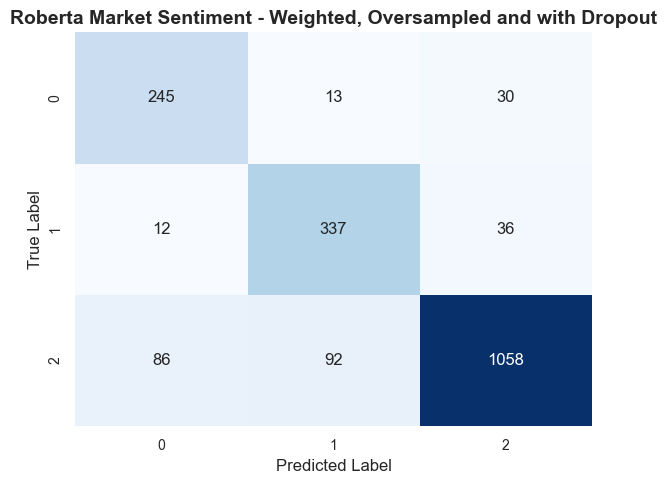

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(val_labels, val_pred_roberta, title=title, labels=[0, 1, 2], cmap="Blues")

## **2.3** GPT-4o (Decoder) - EXTRA

In [ ]:
# Convert Series to list and ensure labels are strings
train_labels = [str(label) for label in data_no_preproc['y_train'].tolist()]
val_labels = [str(label) for label in data_no_preproc['y_val'].tolist()]

In [ ]:
# Label options
label_options = sorted(list(set(train_labels)))

# Generate few-shot examples
few_shot_examples = []
for label in label_options:
    examples = [(t, l) for t, l in zip(train_texts, train_labels) if l == label]
    sample = random.choice(examples)
    few_shot_examples.append({'text': sample[0], 'label': sample[1]})

# Print few-shot examples
print("Few-shot examples:")
for example in few_shot_examples:
    print(f"Text: {example['text']}, Label: {example['label']}")

Few-shot examples:
Text: Phathom Pharmaceuticals EPS of -$9.30, Label: 0
Text: JPMorgan likes Bausch Health in premarket analyst action, Label: 1
Text: Penn Station Stinks, But the Neighborhood Is Looking Up, Label: 2


In [ ]:
# Run (or load cached) classification
train_pred_gpt4o = cached_classification_run("gpt4o_train_preds.pkl", train_texts, label_options, few_shot_examples, client=client, force_reload=False, batch_size=16)
val_pred_gpt4o = cached_classification_run("gpt4o_val_preds.pkl", val_texts, label_options, few_shot_examples, client=client, force_reload=False, batch_size=16)

No cache found. Running classification and saving to gpt4o_train_preds.pkl


Classifying with GPT-4o:   5%|▌         | 25/478 [11:01<3:20:36, 26.57s/it]

Error on input 'How to Make a Killing During t...': Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'medium'}}}}}


Classifying with GPT-4o:  16%|█▌        | 75/478 [33:03<2:55:35, 26.14s/it]

Error on input 'Sanders Targets Buttigieg Over...': Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'medium'}}}}}


Classifying with GPT-4o:  19%|█▉        | 90/478 [39:40<2:51:53, 26.58s/it]

Error on input 'Here's why this video showing ...': Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': True, 'severity': 'high'}, 'violence': {'filtered': False, 'severity': 'safe'}}}}}


Classifying with GPT-4o:  39%|███▉      | 186/478 [1:22:15<2:09:28, 26.61s/it]

Error on input '$hdge shorts getting killed to...': Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'medium'}}}}}


Classifying with GPT-4o:  49%|████▉     | 234/478 [1:43:38<1:48:02, 26.57s/it]

Error on input 'Botswana Sells Rights to Kill ...': Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'medium'}}}}}


Classifying with GPT-4o:  57%|█████▋    | 271/478 [1:59:58<1:33:01, 26.96s/it]

Error on input 'Secret documents reveal how Ch...': Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'medium'}}}}}


Classifying with GPT-4o:  65%|██████▌   | 312/478 [2:18:13<1:12:48, 26.31s/it]

Error on input 'Who’s coming to #RVAilluminate...': Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': True, 'severity': 'high'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'high'}}}}}


Classifying with GPT-4o:  69%|██████▉   | 330/478 [2:26:13<1:06:46, 27.07s/it]

Error on input 'At dinner, man in a wheelchair...': Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': True, 'severity': 'medium'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}}}


Classifying with GPT-4o:  95%|█████████▌| 456/478 [3:22:12<09:45, 26.60s/it]  

Error on input 'Queen Cancels Prince Andrew's ...': Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': True, 'severity': 'high'}, 'violence': {'filtered': False, 'severity': 'low'}}}}}


Classifying with GPT-4o: 100%|██████████| 478/478 [3:31:33<00:00, 26.55s/it]


No cache found. Running classification and saving to gpt4o_val_preds.pkl


Classifying with GPT-4o:   2%|▎         | 3/120 [01:17<50:29, 25.89s/it]

Error on input 'Teeny tiny martinis are taking...': Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': True, 'severity': 'medium'}, 'violence': {'filtered': False, 'severity': 'safe'}}}}}


Classifying with GPT-4o:  94%|█████████▍| 113/120 [49:56<03:05, 26.52s/it]

Error on input 'Wayfair stumbles after Citron ...': Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': True, 'severity': 'medium'}, 'violence': {'filtered': False, 'severity': 'safe'}}}}}


Classifying with GPT-4o: 100%|██████████| 120/120 [52:42<00:00, 26.35s/it]


In [ ]:
# # Filter out unkown labels from both predictions and labels before computing metrics
# clean_preds = []
# clean_labels = []

# for pred, label in zip(train_pred_gpt4o, train_labels):
#     if pred != "unknown":
#         clean_preds.append(pred)
#         clean_labels.append(label)

In [ ]:
# Convert to np.array
X_train_gpt40 = np.array(train_pred_gpt4o)
X_val_gpt40 = np.array(val_pred_gpt4o)

y_train = np.array(train_labels)
y_val = np.array(val_labels)

In [ ]:
# Define the title for the metrics and plots
title = "GPT-4o with Few-shot Examples"

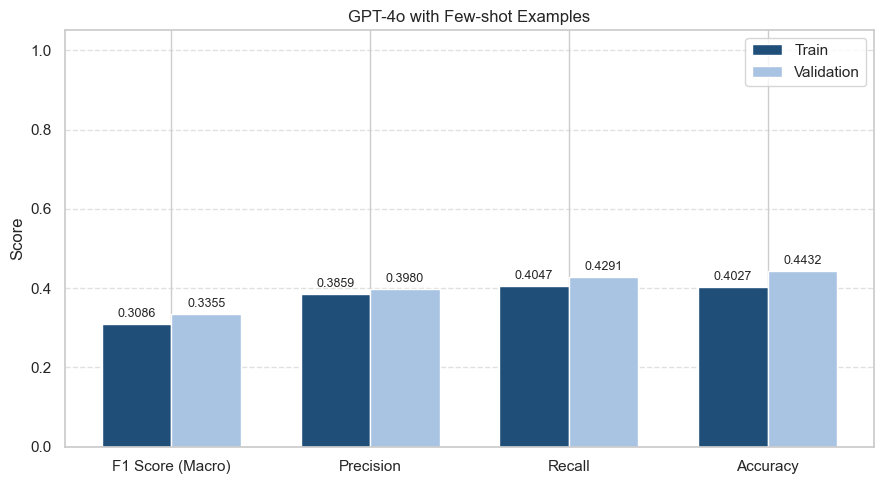

In [ ]:
# Get metrics DataFrame
metrics_df = get_metrics_df(title, train_labels, train_pred_gpt4o, val_labels, val_pred_gpt4o)
metrics_df

# Plot metrics
plot_metrics(train_labels, train_pred_gpt4o, val_labels, val_pred_gpt4o, title=title)

In [ ]:
# # Plot confusion matrix
# plot_confusion_matrix(val_labels, val_pred_gpt4o, title=title, labels=[0, 1, 2], cmap="Blues")